In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
# data_dir = pathlib.Path(data_dir)

import pathlib
data_dir = pathlib.Path('emotions')
train_dir = data_dir / 'train'
val_dir = data_dir / 'test'

In [3]:
batch_size = 32
img_height = 48
img_width = 48

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale')

Found 21005 files belonging to 4 classes.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale')

Found 5212 files belonging to 4 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['angry', 'happy', 'neutral', 'sad']


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 1)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [9]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes)
])

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 48, 48, 1)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)       

In [12]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
657/657 [==============================] - 23s 29ms/step - loss: 1.3581 - accuracy: 0.3455 - val_loss: 1.2693 - val_accuracy: 0.4302
Epoch 2/15
657/657 [==============================] - 18s 27ms/step - loss: 1.2721 - accuracy: 0.4134 - val_loss: 1.1641 - val_accuracy: 0.4870
Epoch 3/15
657/657 [==============================] - 17s 26ms/step - loss: 1.2145 - accuracy: 0.4461 - val_loss: 1.1151 - val_accuracy: 0.5042
Epoch 4/15
657/657 [==============================] - 18s 27ms/step - loss: 1.1785 - accuracy: 0.4737 - val_loss: 1.0953 - val_accuracy: 0.5299
Epoch 5/15
657/657 [==============================] - 17s 27ms/step - loss: 1.1309 - accuracy: 0.4984 - val_loss: 1.1016 - val_accuracy: 0.5248
Epoch 6/15
657/657 [==============================] - 18s 27ms/step - loss: 1.1106 - accuracy: 0.5119 - val_loss: 1.0267 - val_accuracy: 0.5641
Epoch 7/15
657/657 [==============================] - 18s 27ms/step - loss: 1.0820 - accuracy: 0.5248 - val_loss: 1.0443 - val_accuracy:

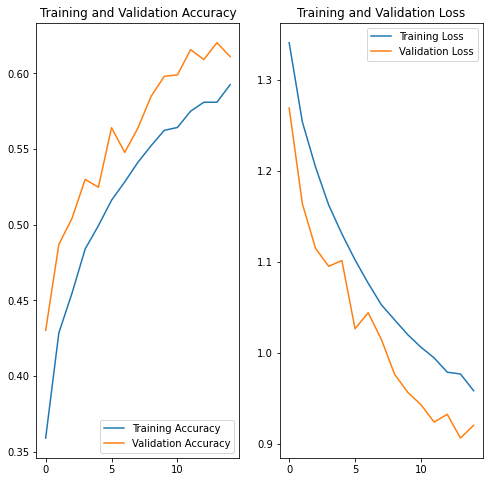

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()